# Imports

In [116]:
import pandas as pd
import numpy as np
# import os

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from numpy.random import normal, uniform, shuffle
# import random

# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, auc
from sklearn.ensemble import RandomForestRegressor

import dill
# import datetime

In [117]:
%matplotlib inline

In [118]:
# SEED = 73 # random seed

In [119]:
dill.dump_session('cache/RandomForest.db')

In [120]:
# dill.load_session('cache/RandomForest.db')

In [121]:
# from google.colab import drive
# drive.mount('/content/drive')

In [122]:
# data_path = 'drive/My Drive/Colab Notebooks/NIR/data/'

# Data reading

## Reading

In [123]:
data_path = 'data/prepared/'

### Synth data for model building

In [124]:
X_train = pd.read_csv(data_path + 'X_train.csv')
X_test = pd.read_csv(data_path + 'X_test.csv')

Y_train = pd.read_csv(data_path + 'y_train.csv')
Y_test = pd.read_csv(data_path + 'y_test.csv')

### Real data for analysis

In [125]:
conditions = ['LD', 'SD']

In [126]:
X_real = {}
Y_real = {}
for cond in conditions:
    X_real[cond] = pd.read_csv(data_path + 'real_X_' + cond + '.csv')
    Y_real[cond] = pd.read_csv(data_path + 'real_Y_' + cond + '.csv')

In [127]:
X_real['LD']

,AP1,FD,FTa1,FTa2,FTa3,FTb,FTc,LFY,TFL1a,TFL1c,days
0,2,31.53,2,8,0.9,3,0,6.4,22.021,25.556,9
1,0,47.62,0,11,0.5,7,0,12.1,20.489,25.263,11
2,6,45.41,1,29,0.8,6,0,21.4,27.397,32.982,13
3,5,40.89,5,60,10.2,28,0,56.8,33.074,39.708,15
4,23,79.47,9,50,1.3,12,0,77.1,42.561,32.222,17
5,33,71.69,40,86,2.5,58,0,48.9,54.798,67.895,20
6,1,25.86,10,18,3.4,7,0,16.0,8.314,11.930,22
7,92,43.31,10,68,4.7,127,0,45.1,18.325,25.731,25
8,19,45.20,10,37,2.1,61,0,27.7,15.851,18.713,28
9,355,81.78,6,52,14.8,102,14,50.9,22.232,29.766,30


In [128]:
Y_real['LD']['days'] = X_real['LD'].days.tolist()[1:] + [40]
Y_real['SD']['days'] = X_real['SD'].days.tolist()[1:] + [34]

## Check the data

In [129]:
X_train.tail()

,AP1,FD,FTa1,FTa2,FTa3,FTb,FTc,LFY,TFL1a,TFL1c,days
11245,588.991212,70.888154,103.077076,93.023388,70.782000,72.425457,41.015956,100.779974,12.677451,20.201277,37
11246,1113.339109,56.924265,74.005610,118.649627,44.217579,104.180986,11.508512,139.423633,15.065515,20.493130,37
11247,900.774255,54.069139,54.113466,96.036398,48.903466,171.118201,54.181371,92.847746,20.507869,15.904987,37
11248,821.903720,63.723559,96.133299,65.631401,124.423143,22.528431,71.695521,95.888681,12.533753,17.714108,37
11249,604.804570,93.748079,97.795785,71.113849,121.149614,13.193296,55.029060,94.574493,17.020120,21.581374,37


In [130]:
X_train.days.value_counts()

31    750
15    750
30    750
22    750
37    750
13    750
28    750
20    750
19    750
11    750
34    750
25    750
17    750
9     750
32    750
Name: days, dtype: int64

In [131]:
Y_train.tail()

,AP1,FD,LFY,TFL1a,TFL1c,days
11245,1251.812881,167.213287,79.448156,18.298156,45.239936,40
11246,1194.070351,99.761610,60.205341,12.583602,59.752023,40
11247,114.166445,114.539155,115.570392,16.489382,52.343561,40
11248,948.621689,123.531040,77.978871,14.202135,36.274194,40
11249,784.562923,137.690553,104.025653,16.390520,76.987036,40


In [132]:
days = list(set(X_test.days.values))
days.append(40)
days.sort()
days

[9, 11, 13, 15, 17, 19, 20, 22, 25, 28, 30, 31, 32, 34, 37, 40]

In [134]:
targets = Y_train.drop('days', axis = 1).columns.tolist()
targets

['AP1', 'FD', 'LFY', 'TFL1a', 'TFL1c']

In [135]:
genes = X_train.drop('days', axis=1).columns.tolist()
genes

['AP1', 'FD', 'FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc', 'LFY', 'TFL1a', 'TFL1c']

In [136]:
FTs = [name for name in genes if name.startswith('FT')]
FTs

['FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc']

In [137]:
X_test.tail()

,AP1,FD,FTa1,FTa2,FTa3,FTb,FTc,LFY,TFL1a,TFL1c,days
3745,1152.078193,77.057377,82.118642,83.302730,118.042212,277.829939,78.337705,123.840171,15.150147,18.504293,37
3746,284.410108,89.115439,74.729687,103.550847,74.380440,221.830060,36.183728,9.734097,18.057826,26.850785,37
3747,752.961542,83.447183,70.001875,113.037540,79.050480,208.505822,14.881454,99.553233,16.537571,18.209133,37
3748,772.521693,60.402778,71.593090,115.201894,190.275172,362.161735,79.106104,85.686811,20.053558,17.480942,37
3749,796.368297,69.968481,20.206926,78.275921,194.341047,367.245787,84.502455,141.943119,14.251000,20.316351,37


## Combine FTs

In [138]:
X_real['LD'][FTs].sum(axis = 1)

0      13.9
1      18.5
2      36.8
3     103.2
4      72.3
5     186.5
6      38.4
7     209.7
8     110.1
9     188.8
10     33.0
11    321.4
12     71.8
dtype: float64

In [139]:
for cond in conditions:
    X_real[cond]['FT'] = X_real[cond][FTs].sum(axis=1)
    X_real[cond] = X_real[cond].drop(['days'] + FTs, axis=1)

X_train['FT'] = X_train[FTs].sum(axis=1)
X_train = X_train.drop(['days'] + FTs, axis=1)

X_test['FT'] = X_test[FTs].sum(axis=1)
X_test = X_test.drop(['days'] + FTs, axis=1)

In [176]:
Y_train = Y_train.drop('days', axis=1)
Y_test = Y_test.drop('days', axis=1)

In [133]:
# X = X_train.drop('days', axis=1)
# Y = Y_train.drop('days', axis=1)

# Random forest

## Model building

In [177]:
def GridS(model, grid, cv, **kwargs):
    return GridSearchCV(model, grid, 
                      n_jobs=-1, 
                      scoring=['neg_mean_squared_error', 'r2'], 
                      refit='neg_mean_squared_error', 
#                       scoring = MSE5,
#                       refit = MSE5,
                      cv=cv, 
                      verbose=10)

In [178]:
len(days) - 1

15

In [179]:
model = RandomForestRegressor()

# cv = TimeSeriesSplit(n_splits=5) # number of splits must be divider of days-1
cv = KFold(n_splits=5, shuffle=True)
grid = {
    'n_estimators': [10, 20, 50, 100, 300],
    'min_samples_leaf': [10, 20, 50],
    'max_depth': [6, 7, 8, None]
}

In [180]:
gs = GridS(model, grid, cv)

In [181]:
gs.fit(X_train.values, Y_train.values)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 50, 100, 300], 'min_samples_leaf': [10, 20, 50], 'max_depth': [6, 7, 8, None]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring=['neg_mean_squared_error', 'r2'],
       verbose=10)

In [182]:
gs.best_params_

{'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 300}

Get the model with best score on the cross-validation:

In [183]:
best_model = gs.best_estimator_

In [184]:
predictions_train = best_model.predict(X_train.values)
predictions_test = best_model.predict(X_test.values)

## Evaluating

In [185]:
def print_scores(true_values, predictions):
    MSEs = mean_squared_error(true_values.values, predictions, multioutput='raw_values').round(2)
    R2 = r2_score(true_values.values, predictions, multioutput='raw_values').round(2)
    r = [] 
    for i in range(len(targets)):
        r.append(np.corrcoef(true_values.values.transpose()[i], predictions.transpose()[i]).round(2)[0, 1])
    df = pd.DataFrame({'MSE': MSEs,'R2': R2, 'r': r}, index=targets, )
    return df

In [186]:
def comparsion_plot(true_values, predictions, data_type = 'train', current_target=targets[0]):
    plt.scatter(true_values, predictions)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r')
    plt.xlabel('True Values' + ' (' + current_target + ')')
    plt.ylabel('Predictions' + ' (' + current_target + ')')
    plt.axis('equal')
    plt.axis('square')
    plt.title('Predictions on ' + data_type)
#     plt.savefig('results/' + current_target + '_' + data_type + '.png', bbox_inches='tight', dpi=300)
    plt.show()

Scores on train:  
(r - Pearson correlation)

In [187]:
print_scores(Y_train, predictions_train)

,MSE,R2,r
AP1,12614.35,0.87,0.93
FD,143.50,0.79,0.89
LFY,2009.31,0.65,0.82
TFL1a,30.80,0.83,0.91
TFL1c,46.23,0.78,0.89


Scores on test:

In [188]:
print_scores(Y_test, predictions_test)

,MSE,R2,r
AP1,18914.32,0.80,0.90
FD,161.53,0.76,0.87
LFY,2820.29,0.52,0.72
TFL1a,35.95,0.80,0.90
TFL1c,51.68,0.75,0.87


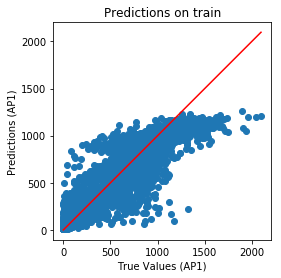

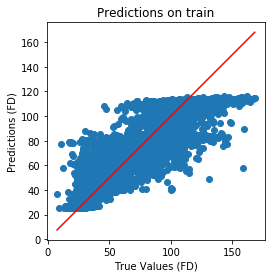

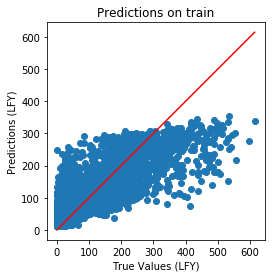

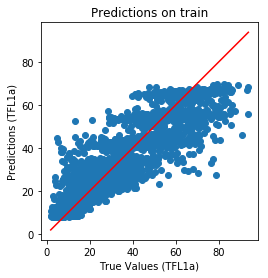

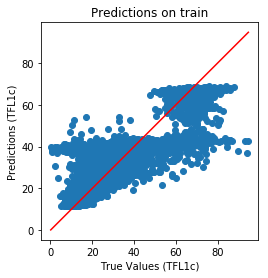

In [189]:
for i in range(5):
    comparsion_plot(Y.iloc[:, i], predictions_train[:, i], data_type='train', current_target=targets[i])

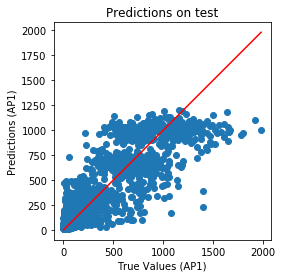

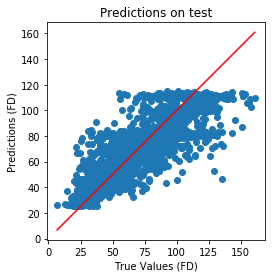

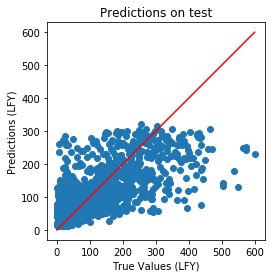

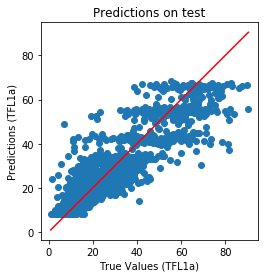

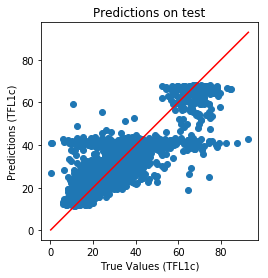

In [191]:
for i in range(5):
    comparsion_plot(Y_test.iloc[:, i], predictions_test[:, i], data_type='test', current_target=targets[i])

In [ ]:
gs.best_params_

In [ ]:
# total_model = RandomForestRegressor(min_samples_leaf=10, n_estimators=100)
# total_model.fit(X, Y)

# Real data

In [192]:
def time_long_plot(true_values, predicted, condition = 'LD'):
    for i in range(5):
        plt.plot(true_values['days'], true_values.iloc[:,i].values, 'o')
        plt.plot(true_values['days'], predicted[:, i], '-')
        plt.title(targets[i] + ' ' + condition)
        plt.xlabel('days')
        plt.ylabel('rltv expr lvl')
        plt.legend(['true values', 'predictions'])
#         plt.savefig('results/' + '{t}_{c}_pred_on_real.png'.format(t=targets[i], c=condition), 
#                     bbox_inches='tight', dpi=300)
        plt.show()

In [196]:
predictions_real = {}
predictions_real['LD'] = best_model.predict(X_real['LD'].values)
predictions_real['SD'] = best_model.predict(X_real['SD'].values)

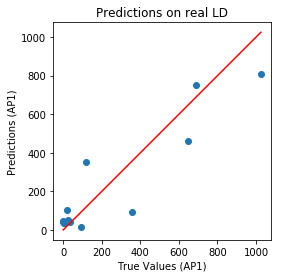

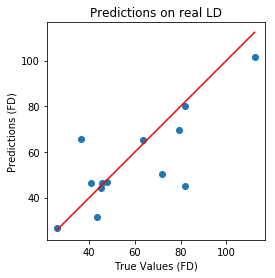

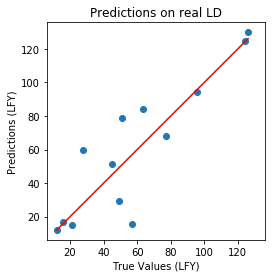

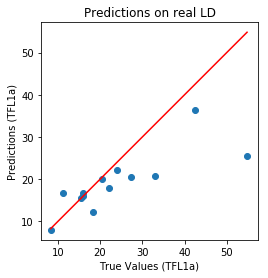

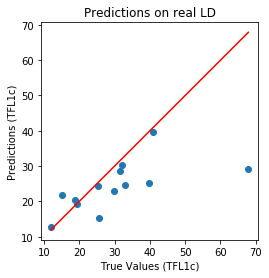

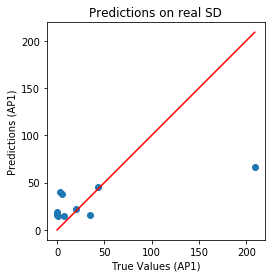

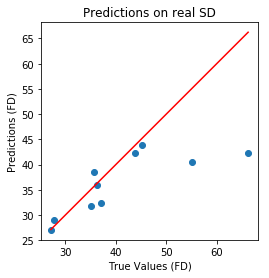

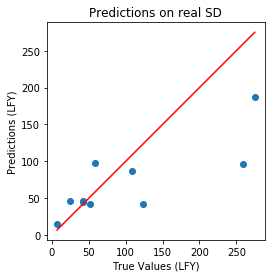

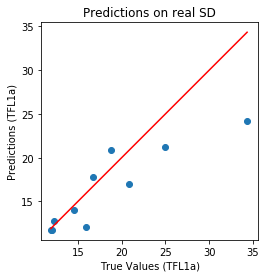

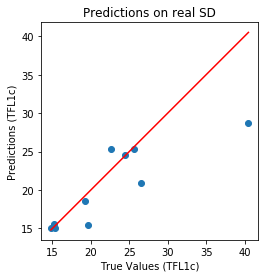

In [197]:
for cond in conditions:
    for i in range(5):
        comparsion_plot(Y_real[cond].iloc[:, i], predictions_real[cond][:, i], data_type='real ' + cond, current_target=targets[i])

In [198]:
for cond in conditions:
    print(cond)
    print(print_scores(Y_real[cond].drop('days', axis=1), predictions_real[cond]))

LD
            MSE    R2     r
AP1    17666.49  0.84  0.92
FD       235.80  0.57  0.78
LFY      344.52  0.74  0.88
TFL1a     91.42  0.42  0.80
TFL1c    153.65  0.20  0.63
SD
           MSE    R2     r
AP1    2388.33  0.35  0.78
FD       83.74  0.37  0.78
LFY    4384.72  0.46  0.81
TFL1a    15.21  0.66  0.90
TFL1c    19.55  0.64  0.86


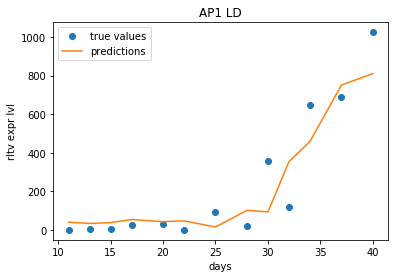

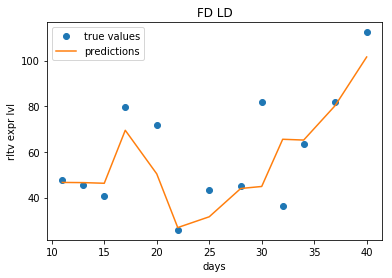

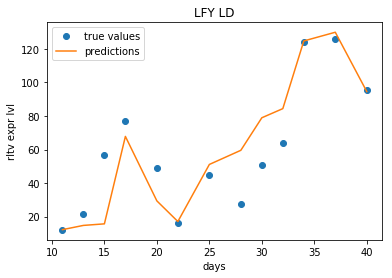

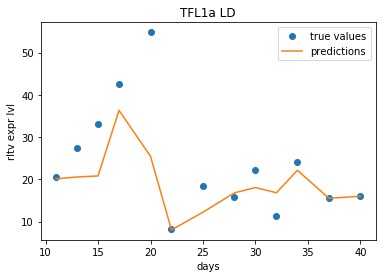

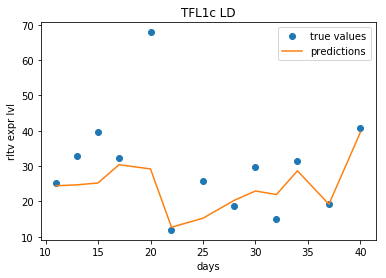

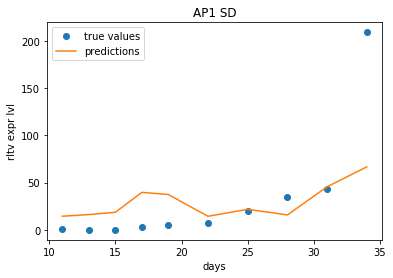

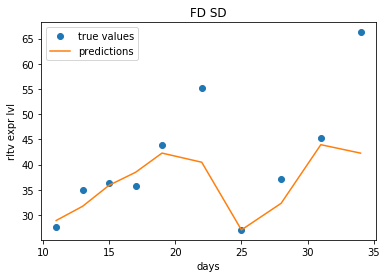

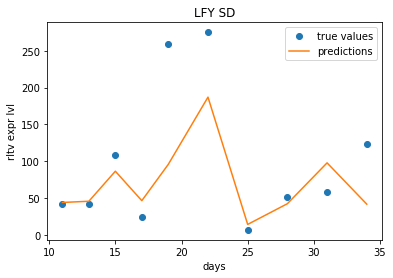

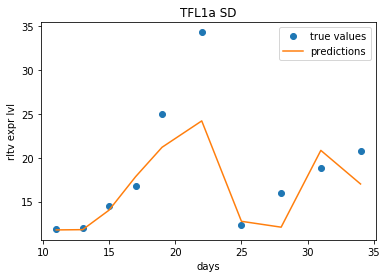

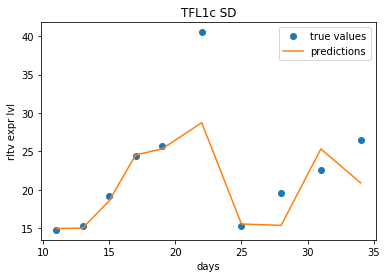

In [199]:
for cond in conditions:
    time_long_plot(Y_real[cond], predictions_real[cond], cond)

# Knock out simulation

In [200]:
genes

['AP1', 'FD', 'FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc', 'LFY', 'TFL1a', 'TFL1c']

In [201]:
def time_long_plot_ko(true_values, predicted, pred_for_ko, KO_gene, condition):
    for i in range(5):
        x_axis = true_values['days']
        plt.plot(x_axis, true_values.iloc[:,i].values, 'o')
        plt.plot(x_axis, predicted[:, i], '--')
        plt.plot(x_axis, pred_for_ko[:, i], '-')
        plt.title(targets[i] + ' ({c} with {KO} KO)'.format(c=condition, KO=KO_gene))
        plt.xlabel('days')
        plt.ylabel('rltv expr lvl')
        plt.legend(['true values', 'predictions on WT', 'predictions with KO'])
#         plt.savefig('results/KOs/{t}/{t}_{c}_with_{KO}_KO.png'.format(t=targets[i], c=condition, KO=KO_gene), 
#                     bbox_inches='tight', dpi=300)
        plt.show()

In [223]:
def get_aucs(true_values, predictions, x_ax):
    aucs = pd.DataFrame(index = ['WT', 'KO', 'difference'], columns=targets)
    
    days_axis = x_ax
    
    for i in range(len(targets)):
        true_auc = auc(days_axis, true_values[:, i]).round(2)
        pred_auc = auc(days_axis, predictions[:, i]).round(2)
        aucs[targets[i]] = [true_auc, pred_auc, (pred_auc - true_auc).round(2)]
        
    return aucs

In [202]:
targets_with_cond = [name + '_LD' for name in targets]
targets_with_cond = targets_with_cond + [name + '_SD' for name in targets]

In [203]:
targets_with_cond

['AP1_LD',
 'FD_LD',
 'LFY_LD',
 'TFL1a_LD',
 'TFL1c_LD',
 'AP1_SD',
 'FD_SD',
 'LFY_SD',
 'TFL1a_SD',
 'TFL1c_SD']

In [204]:
# def get_aucs(true_values, predictions, x_ax):
#     aucs = pd.DataFrame(index = targets_with_cond, columns=['WT'] + genes)
    
#     days_axis = x_ax
    
#     for i in range(len(targets)):
#         true_auc = auc(days_axis, true_values[:, i]).round(2)
#         pred_auc = auc(days_axis, predictions[:, i]).round(2)
#         aucs[targets[i]] = [true_auc, pred_auc, (pred_auc - true_auc).round(2)]
        
#     return aucs

## Single-gene KO

In [215]:
genes = sorted(list(set(genes) - set(FTs)) + ['FT'])

In [216]:
genes

['AP1', 'FD', 'FT', 'LFY', 'TFL1a', 'TFL1c']

In [217]:
ko_genes = genes

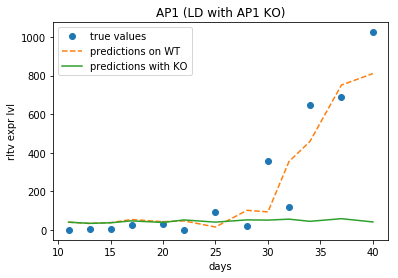

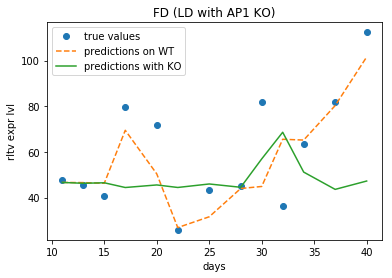

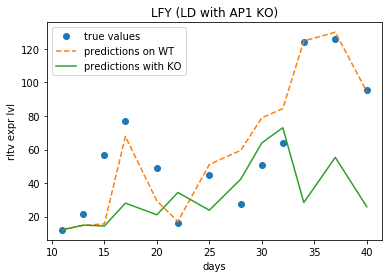

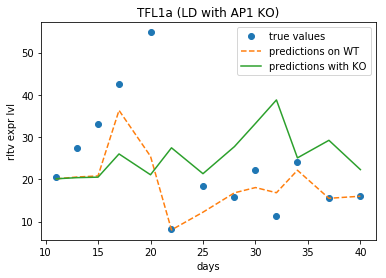

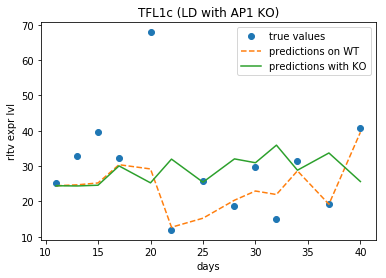

AP1 KO
                AP1       FD      LFY   TFL1a   TFL1c
WT          6352.33  1580.90  1830.97  551.41  679.94
KO          1337.91  1398.03  1007.25  749.28  842.40
difference -5014.42  -182.87  -823.72  197.87  162.46


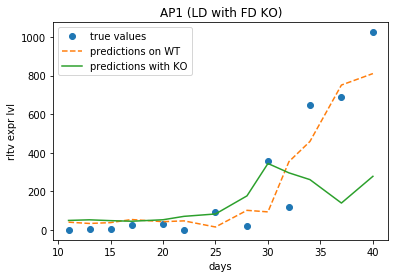

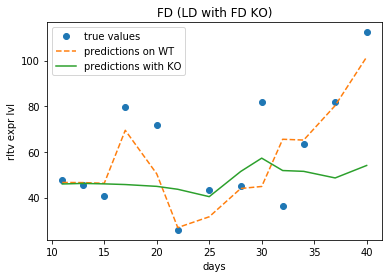

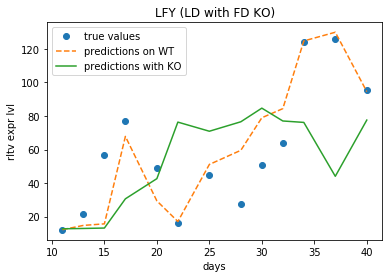

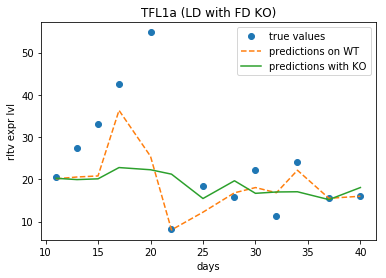

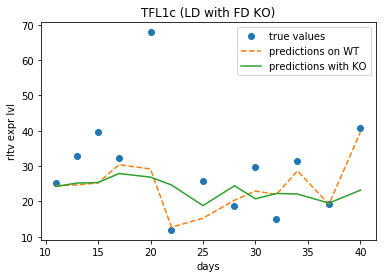

FD KO
                AP1       FD      LFY   TFL1a   TFL1c
WT          6352.33  1580.90  1830.97  551.41  679.94
KO          4127.13  1389.84  1605.39  544.01  675.97
difference -2225.20  -191.06  -225.58   -7.40   -3.97


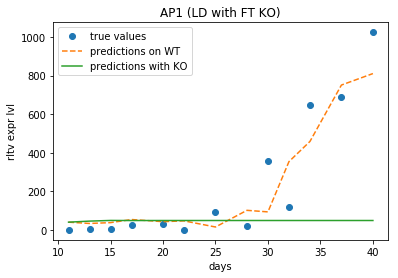

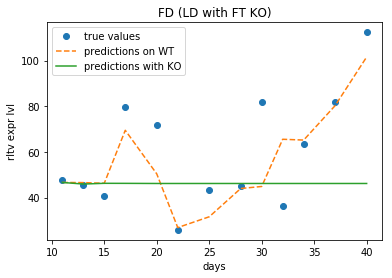

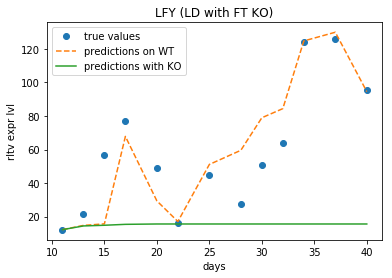

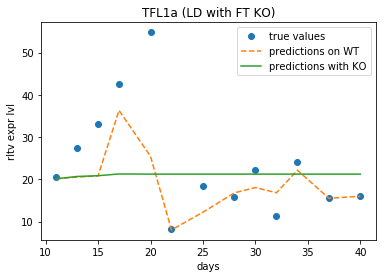

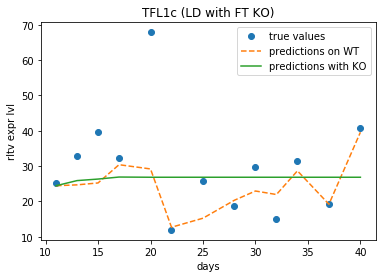

FT KO
                AP1       FD      LFY   TFL1a   TFL1c
WT          6352.33  1580.90  1830.97  551.41  679.94
KO          1400.70  1339.54   445.60  612.53  773.23
difference -4951.63  -241.36 -1385.37   61.12   93.29


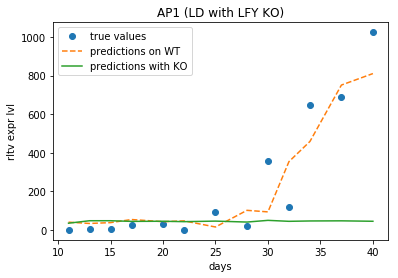

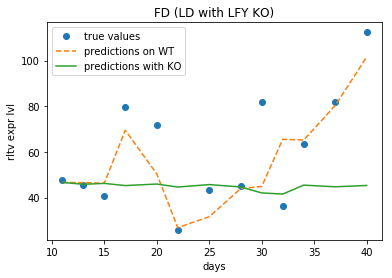

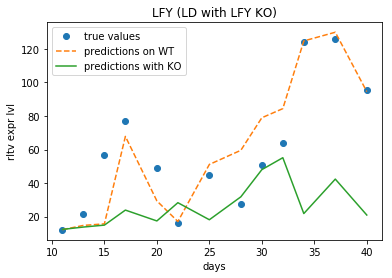

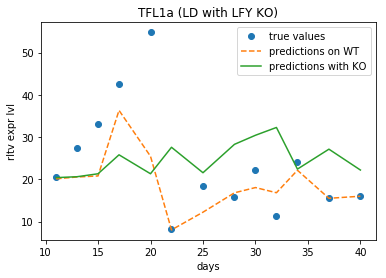

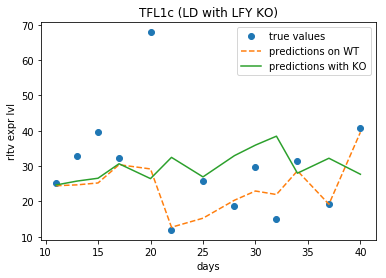

LFY KO
                AP1       FD      LFY   TFL1a   TFL1c
WT          6352.33  1580.90  1830.97  551.41  679.94
KO          1307.01  1302.06   797.64  722.29  873.47
difference -5045.32  -278.84 -1033.33  170.88  193.53


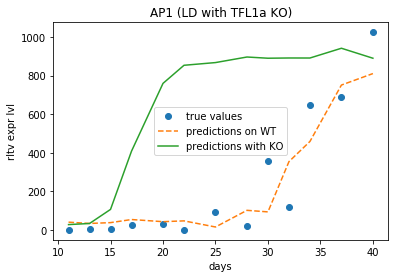

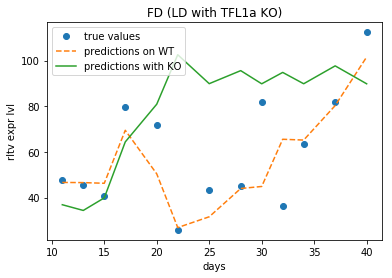

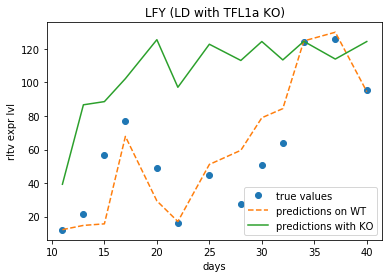

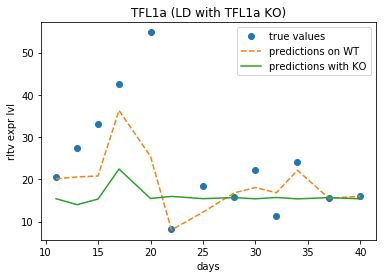

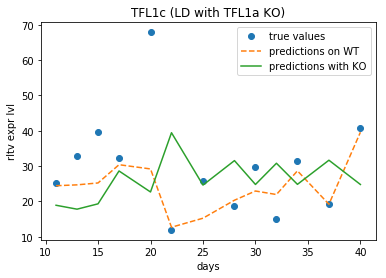

TFL1a KO
                 AP1       FD      LFY   TFL1a   TFL1c
WT           6352.33  1580.90  1830.97  551.41  679.94
KO          20159.77  2334.84  3167.49  464.68  778.21
difference  13807.44   753.94  1336.52  -86.73   98.27


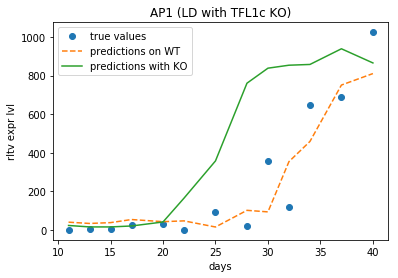

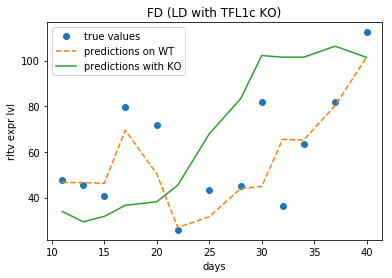

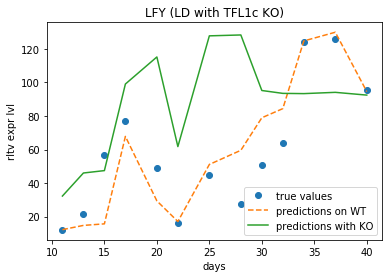

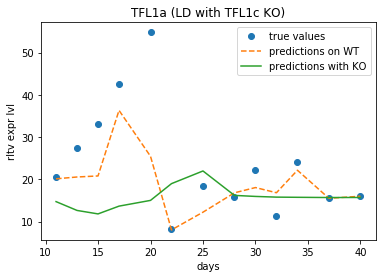

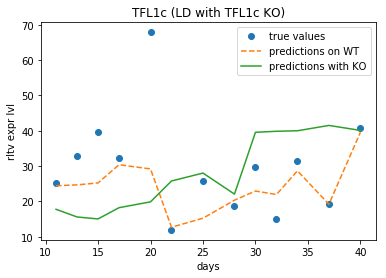

TFL1c KO
                 AP1      FD      LFY   TFL1a   TFL1c
WT           6352.33  1580.9  1830.97  551.41  679.94
KO          13272.71  2000.5  2644.29  462.41  821.54
difference   6920.38   419.6   813.32  -89.00  141.60


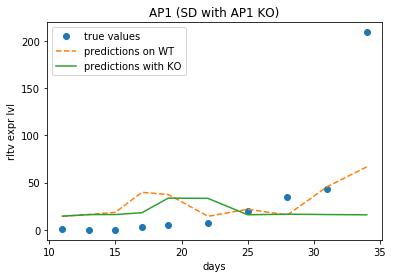

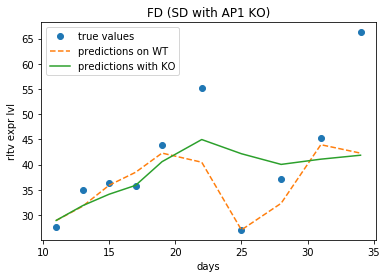

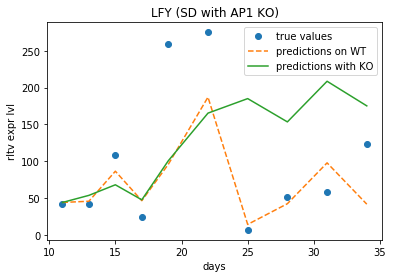

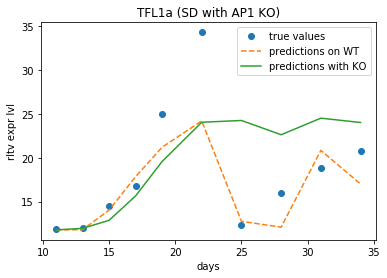

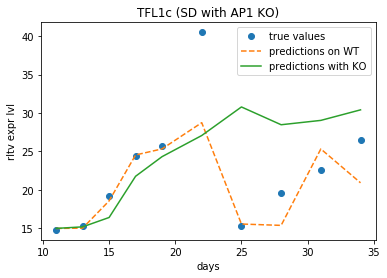

AP1 KO
               AP1      FD      LFY   TFL1a   TFL1c
WT          650.09  841.87  1730.71  387.11  481.16
KO          470.47  901.83  3035.59  463.93  574.39
difference -179.62   59.96  1304.88   76.82   93.23


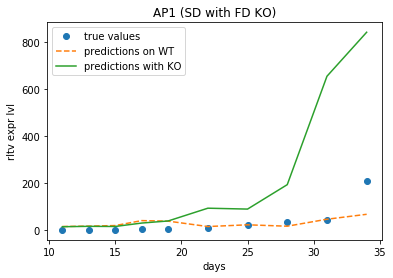

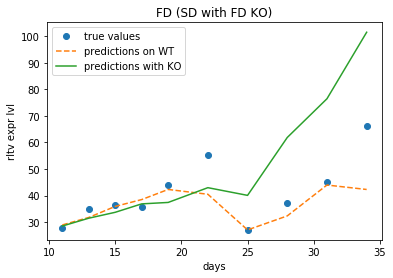

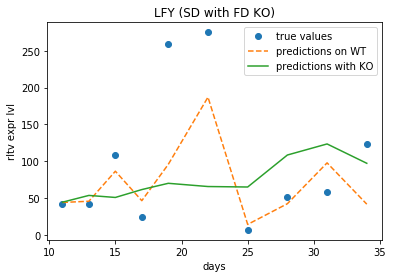

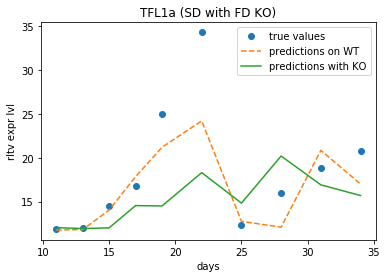

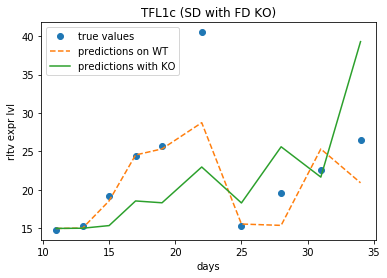

FD KO
                AP1       FD      LFY   TFL1a   TFL1c
WT           650.09   841.87  1730.71  387.11  481.16
KO          4584.06  1142.12  1788.37  359.31  483.39
difference  3933.97   300.25    57.66  -27.80    2.23


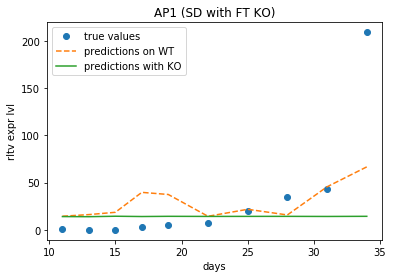

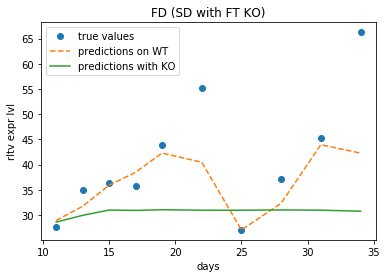

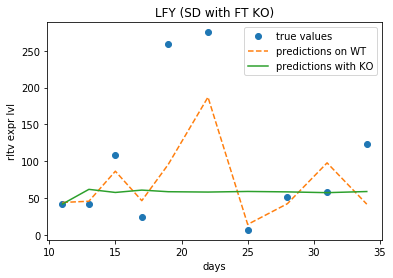

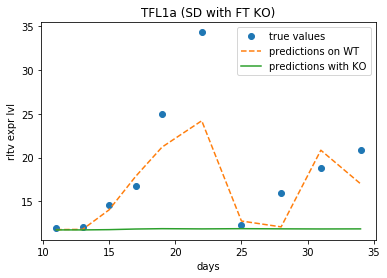

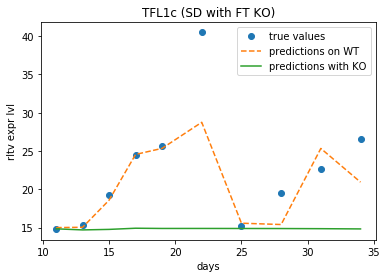

FT KO
               AP1      FD      LFY   TFL1a   TFL1c
WT          650.09  841.87  1730.71  387.11  481.16
KO          328.32  708.01  1339.79  271.93  341.44
difference -321.77 -133.86  -390.92 -115.18 -139.72


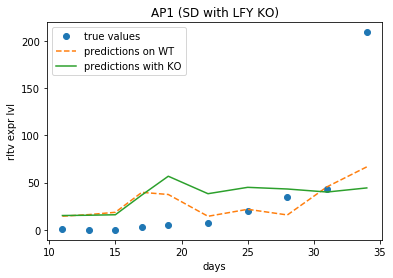

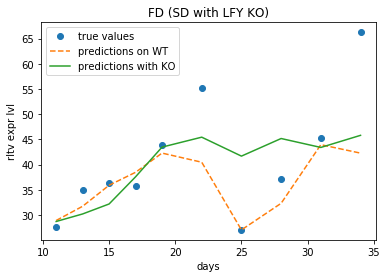

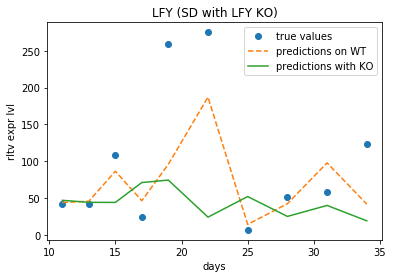

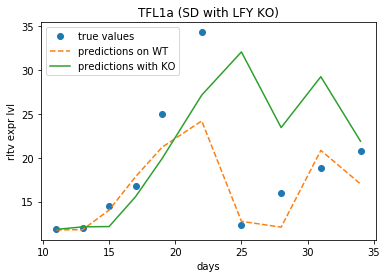

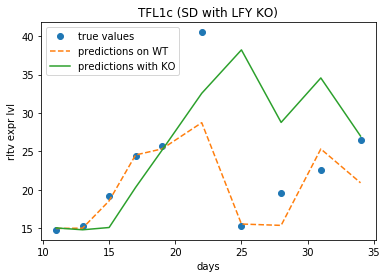

LFY KO
               AP1      FD      LFY   TFL1a   TFL1c
WT          650.09  841.87  1730.71  387.11  481.16
KO          860.42  933.35  1008.57  509.81  621.36
difference  210.33   91.48  -722.14  122.70  140.20


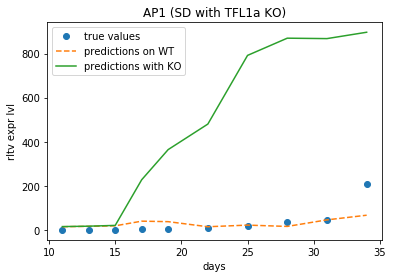

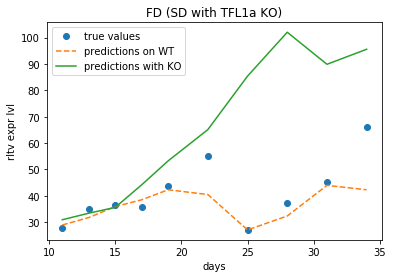

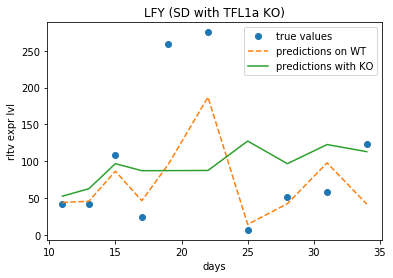

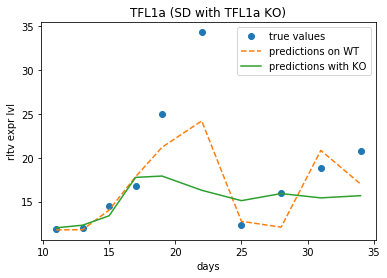

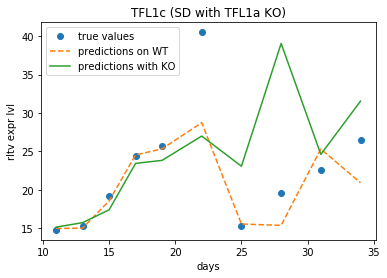

TFL1a KO
                 AP1       FD      LFY   TFL1a   TFL1c
WT            650.09   841.87  1730.71  387.11  481.16
KO          11827.77  1560.84  2238.61  355.26  576.62
difference  11177.68   718.97   507.90  -31.85   95.46


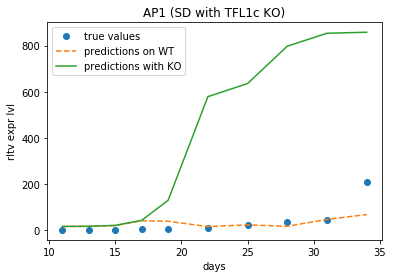

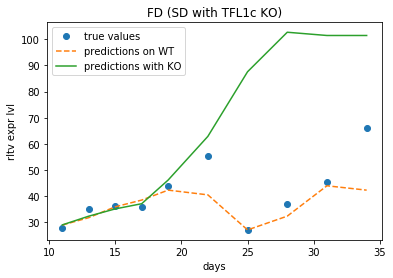

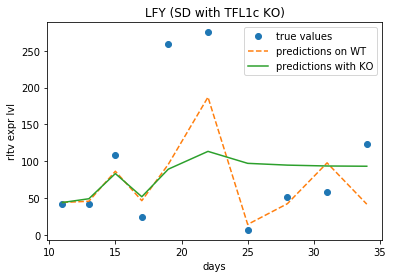

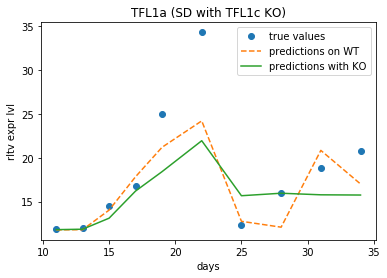

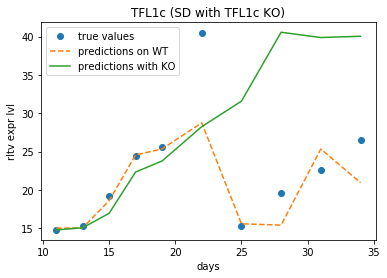

TFL1c KO
                 AP1       FD      LFY   TFL1a   TFL1c
WT            650.09   841.87  1730.71  387.11  481.16
KO          10370.56  1569.46  1974.56  371.67  663.66
difference   9720.47   727.59   243.85  -15.44  182.50


In [224]:
for cond in conditions:
    for ko_name in ko_genes:
        X_ko = X_real[cond].copy()
        X_ko = X_ko

        pred_ko = [0 for i in range(len(X_ko))]
        
        for i in range(len(X_ko)):
            X_ko[ko_name] = 0
            pred_ko[i] = best_model.predict(X_ko.iloc[i, :].values.reshape(1, -1))
            X_ko[targets] = pred_ko[i][0]

        pred_ko = np.array(pred_ko).squeeze()
        
        time_long_plot_ko(Y_real[cond], predictions_real[cond], pred_ko, KO_gene=ko_name, condition=cond)
        
        AUCs = get_aucs(predictions_real[cond], pred_ko, Y_real[cond].days)
        
#         with open('results/KOs/aucs.txt', 'a') as ouf:
#             ouf.write('{KO} KO ({c})'.format(KO=ko_name, c=cond))
#             ouf.write('\n')
#             AUCs.to_csv(ouf)
#             ouf.write('\n')
#             ouf.write('\n')
        
        print(ko_name + ' KO')
        print(AUCs)

## Two FTs KO

**Redefine tlplot for for correct FT pairs processing:**

In [ ]:
def time_long_plot_ko(true_values, predicted, pred_for_ko, KO_gene, condition):
    for i in range(5):
        x_axis = true_values['days']
        plt.plot(x_axis, true_values.iloc[:,i].values, 'o')
        plt.plot(x_axis, predicted[:, i], '--')
        plt.plot(x_axis, pred_for_ko[:, i], '-')
        plt.title(targets[i] + ' ({c} with {KO} KO)'.format(c=condition, KO=', '.join(KO_gene))) # for correct title
        plt.xlabel('days')
        plt.ylabel('rltv expr lvl')
        plt.legend(['true values', 'predictions on WT', 'predictions with KO'])
        plt.savefig('results/FT_pairs_KOs/{t}/{t}_{c}_with_{KO}_KO.png'.format(t=targets[i], c=condition, 
                                                                               KO='_'.join(KO_gene)), 
                    bbox_inches='tight', dpi=300)
        plt.show()

In [ ]:
import itertools

In [ ]:
FT_pairs = list(itertools.combinations(FTs, 2))
FT_pairs

In [ ]:
ko_genes = FT_pairs

In [ ]:
for cond in conditions:
    for ko_name in ko_genes:
        X_ko = X_real[cond].copy()
        X_ko = X_ko.drop('days', axis = 1)

        pred_ko = [0 for i in range(len(X_ko))]
        
        for i in range(len(X_ko)):
            X_ko[ko_name[0]] = 0
            X_ko[ko_name[1]] = 0
            
            pred_ko[i] = best_model.predict(X_ko.iloc[i, :].values.reshape(1, -1))
            X_ko[targets] = pred_ko[i][0]

        pred_ko = np.array(pred_ko).squeeze()
        
        time_long_plot_ko(Y_real[cond], predictions_real[cond], pred_ko, KO_gene=ko_name, condition=cond)
        
        AUCs = get_aucs(predictions_real[cond], pred_ko, Y_real[cond].days)
        
        with open('results/KOs/aucs_FT_pairs.txt', 'a') as ouf:
            ouf.write('{KO} KO ({c})'.format(KO=ko_name, c=cond))
            ouf.write('\n')
            AUCs.to_csv(ouf)
            ouf.write('\n')
            ouf.write('\n')
        
        print(', '.join(ko_name) + ' KO')
        print(AUCs)

## Three FTs KO

In [ ]:
FT_trios = list(itertools.combinations(FTs, 3))
FT_trios

In [ ]:
ko_genes = FT_trios

In [ ]:
for cond in conditions:
    for ko_name in ko_genes:
        X_ko = X_real[cond].copy()
        X_ko = X_ko.drop('days', axis = 1)

        pred_ko = [0 for i in range(len(X_ko))]
        
        for i in range(len(X_ko)):
            X_ko[ko_name[0]] = 0
            X_ko[ko_name[1]] = 0
            
            pred_ko[i] = best_model.predict(X_ko.iloc[i, :].values.reshape(1, -1))
            X_ko[targets] = pred_ko[i][0]

        pred_ko = np.array(pred_ko).squeeze()
        
        time_long_plot_ko(Y_real[cond], predictions_real[cond], pred_ko, KO_gene=ko_name, condition=cond)
        
        AUCs = get_aucs(predictions_real[cond], pred_ko, Y_real[cond].days)
        
        with open('results/KOs/aucs_FT_trios.txt', 'a') as ouf:
            ouf.write('{KO} KO ({c})'.format(KO=ko_name, c=cond))
            ouf.write('\n')
            AUCs.to_csv(ouf)
            ouf.write('\n')
            ouf.write('\n')
        
        print(', '.join(ko_name) + ' KO')
        print(AUCs)

## Four FTs KO

In [ ]:
FT_quads = list(itertools.combinations(FTs, 4))
FT_quads

In [ ]:
ko_genes = FT_quads

In [ ]:
for cond in conditions:
    for ko_name in ko_genes:
        X_ko = X_real[cond].copy()
        X_ko = X_ko.drop('days', axis = 1)

        pred_ko = [0 for i in range(len(X_ko))]
        
        for i in range(len(X_ko)):
            X_ko[ko_name[0]] = 0
            X_ko[ko_name[1]] = 0
            
            pred_ko[i] = best_model.predict(X_ko.iloc[i, :].values.reshape(1, -1))
            X_ko[targets] = pred_ko[i][0]

        pred_ko = np.array(pred_ko).squeeze()
        
        time_long_plot_ko(Y_real[cond], predictions_real[cond], pred_ko, KO_gene=ko_name, condition=cond)
        
        AUCs = get_aucs(predictions_real[cond], pred_ko, Y_real[cond].days)
        
        with open('results/KOs/aucs_FT_trios.txt', 'a') as ouf:
            ouf.write('{KO} KO ({c})'.format(KO=ko_name, c=cond))
            ouf.write('\n')
            AUCs.to_csv(ouf)
            ouf.write('\n')
            ouf.write('\n')
        
        print(', '.join(ko_name) + ' KO')
        print(AUCs)

# AUCs barplots

In [ ]:
AUC = pd.read_csv('results/AUCs.csv', index_col = 0, sep=';')

In [ ]:
AUC.T

In [ ]:
AUC.WT['AP1_LD']

In [ ]:
AUC.T.loc['WT']['AP1_LD']

In [ ]:
def all_barplots(dataframe, transpose = False):
    if transpose:
        df = dataframe.T
    else:
        df = dataframe
    
    for col in df.columns:
        plt.figure(figsize=(20,10))
        myplot = sns.barplot(y = col, x = df.index, data = df)
        plt.xticks(rotation=60)
        plt.title(col.replace('_', ' '))
        myplot.axes.axhline(df.loc['WT'][col], dashes=(5, 1))
        
        plt.savefig('results/barplots/{c}.png'.format(c = col), bbox_inches='tight', dpi=300)
        plt.show()

In [ ]:
all_barplots(AUC, transpose=True)

# Save and load the model

In [ ]:
dill.dump_session('cache/RandomForest.db')

In [ ]:
dill.load_session('cache/RandomForest.db')

## Some trash

In [ ]:
# import torch

In [ ]:
# model_save_name = 'RF_regressor.pt'
# # path = F"/content/gdrive/My Drive/{model_save_name}" 
# model_path = data_path + model_save_name
# torch.save(total_model.state_dict(), model_path)

In [ ]:
def logging(description, out):
    string = str(description) + ': ' + str(out)
    with open('results/log.txt', 'a') as out_file:
        out_file.write(string + '\n')
    print(string)

In [ ]:
# def clear_log():
#     with open('results/NN/NN_log.txt', 'w') as out_file:
#         out_file.write('log file have been cleared ' + str(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S')))